# Item Search Using Image Embedding

    - given a query item find the similar items using pre-computed embeddings
    - given a query image create an outfit with the highest compatibility score

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import heapq
import json
import numpy
import os
import pickle
import random
from tqdm import tqdm
import tensorflow as tf

%pylab inline
import matplotlib.pyplot as plt

from data_process import OutfitGen

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "disjoint" # "nondisjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
model_name = "efficientnet"
checkpoint_filepath = base_dir + "/checkpoint"
image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
data_type = "nondisjoint"
model_type = "rnn"
max_seq_len = 8
item_file = "polyvore_item_metadata.json"

In [9]:
def plot_similar_images(similar_items):
    nrows, ncols = 1, len(similar_items)
    figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
    items = [tup[1] for tup in similar_items]
    for ii in range(ncols):
        item = items[ii]
        img = plt.imread(os.path.join(image_dir, item + ".jpg"))
        imgplot = axis[ii].imshow(img)
        axis[ii].axis('off')
    plt.show()

def plot_current_outfits(outfits, figsize=(20, 100)):
    nrows = len(outfits)
    ncols = [len(o) for o in outfits][0]
    figure, axis = plt.subplots(nrows, ncols, figsize=figsize)
    for ii in range(nrows):
        items = outfits[ii]
        for jj in range(ncols):
            item = items[jj]
            img = plt.imread(os.path.join(image_dir, item + ".jpg"))
            imgplot = axis[ii][jj].imshow(img)
#             axis[ii][jj].title.set_text(cats[count])
            axis[ii][jj].axis('off')
    plt.show()
    

## Find similar images

In [31]:
with open(image_embedding_file, "rb") as fr:
    image_embedding_dict = pickle.load(fr)
print(f"Loaded {len(image_embedding_dict)} image embeddings")

Loaded 261057 image embeddings


Get a query image and search similar ones from the dictionary

In [5]:
all_files = [image for image in glob.glob(f"{image_dir}/*.jpg")]

In [10]:
# query = random.sample(all_files, k=1)[0]
query = all_files[np.random.randint(len(all_files), size=1)[0]]
q_vec = image_embedding_dict[query.split("/")[-1].split('.')[0]].numpy()
image_dist = []
for image, i_vec in tqdm(image_embedding_dict.items()):
    dist = numpy.linalg.norm(q_vec - i_vec.numpy())
    heapq.heappush(image_dist, (dist, image))


100%|██████████| 261057/261057 [00:03<00:00, 65269.63it/s]


In [12]:
top_images = [heapq.heappop(image_dist) for _ in range(5)]
top_images

[(0.0, '143826018'),
 (4.376688, '193790922'),
 (4.5180874, '157538511'),
 (4.5374994, '165910825'),
 (4.6941495, '196200134')]

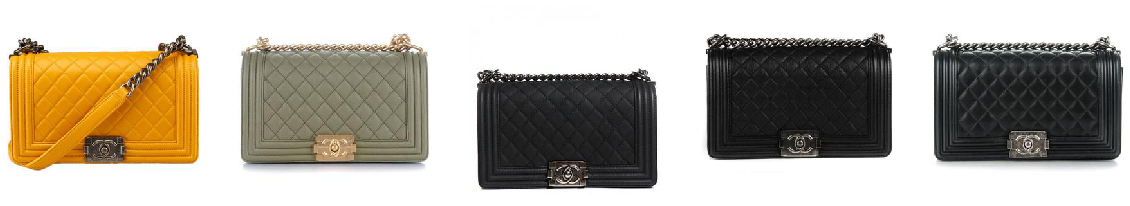

In [13]:
plot_similar_images(top_images)

In [14]:
zalando_image_dir = "/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female"
zalando_files = [image for image in glob.glob(f"{zalando_image_dir}/*.jpg")]

In [15]:
zalando_files[:10]

['/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/SE421C03G-K11@9.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/NAA21N00Y-O11@2.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/C2Q21J001-C11@7.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/TP751L0M6-Q11@6.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/S5981R004-J11@2.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/PO221I07B-J11@2.3.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/VEI11B001-Q11@9.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/F1481J00C-N11@2.2.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/L4621C0DM-O11@12.1.jpg',
 '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/ONA21E08G-K11@2.2.jpg']

In [16]:

image = tf.keras.preprocessing.image.load_img('/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/SE421C03G-K11@9.jpg')

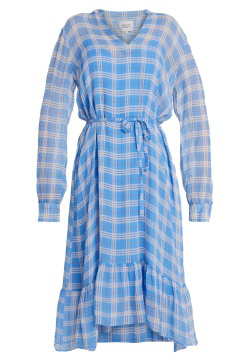

In [17]:
image

In [19]:
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_arr.shape

(361, 250, 3)

In [21]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model = tf.keras.models.load_model(f"finetuned_{model_name}")
new_model = tf.keras.models.Sequential(
    [tf.keras.layers.InputLayer(input_shape=[224, 224, 3]), model.layers[0]]
)
print(new_model.summary())
image_path = '/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/SE421C03G-K11@9.jpg'
image = tf.keras.preprocessing.image.load_img(image_path)
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
image_arr /= 255.0
image_embed = tf.squeeze(new_model(tf.expand_dims(image_arr, 0)))
image_embed.shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetv2-b0 (EffNetV2M (None, 1280)              5919312   
Total params: 5,919,312
Trainable params: 5,858,704
Non-trainable params: 60,608
_________________________________________________________________
None


TensorShape([1280])

In [22]:
q_vec = image_embed

In [23]:
image_dist = []
for image, i_vec in tqdm(image_embedding_dict.items()):
    dist = numpy.linalg.norm(q_vec - i_vec.numpy())
    heapq.heappush(image_dist, (dist, image))


100%|██████████| 261057/261057 [01:47<00:00, 2424.83it/s]


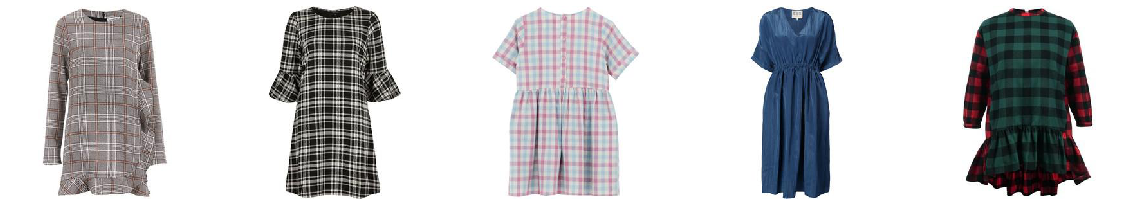

In [24]:
top_images = [heapq.heappop(image_dist) for _ in range(5)]
plot_similar_images(top_images)

## Outfit Creation

    1. Given a query image, find top B images that would constitute an outfit based on the compatibility model
    2. for each of this image, get the top-B images that would constitute 3-item outfits
    3. continue like this till there are 8 images (always keeping top-B images in the pool)

In [5]:
model = tf.keras.models.load_model(f"compatibility_{data_type}_{model_type}_model_{max_seq_len}")
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8, 1280)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 8, 768)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Sum (TensorFlowOpLa (None, 8)            0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sum_1 (TensorFlowOp (None, 8)            0           input_5[0][0]                    
________________________________________________________________________________________________

In [23]:
query

'/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits/images/129978068.jpg'

In [6]:
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)

In [47]:
def return_top_items(query_item, max_item=8):
    if type(query_item) is not list:
        query_item = [query_item]
    data_gen = OutfitGen(embed_dir=embed_dir,
                         image_embed_file="effnet_tuned_polyvore.pkl",
                         text_embed_file="bert_polyvore.pkl",
                         batch_size=256,
                         max_len=max_item,
                         image_embedding_dim=1280,
                         query_item=query_item
                        )
    pbar = tqdm(range(len(data_gen)))
    current_score = []
    for ii in pbar:
        x, items = data_gen[ii]
        yhat = model(x)
        for cs, item in zip(yhat, items):
            heapq.heappush(current_score, (1-cs, query_item + [str(item)]))  # it's a min-heap
    return current_score

def filter_outfits(outfits, max_len):
    count = 0
    filtered = []
    while count < max_len: 
        outfit = heapq.heappop(outfits)
        items = outfit[1]
        categories = [pv_items[item]['semantic_category'] for item in items]
        if len(set(categories)) == len(categories):
            filtered.append(items)
            count += 1
    return filtered

def create_outfit(query, model, max_item=8, beam_length=10):

    # add the first item - only one run
    first_score = return_top_items(query)
    current_items = filter_outfits(first_score, beam_length)
    plot_current_outfits(current_items, figsize=(10, beam_length * 2))
    
    for jj in range(len(query)+1, max_item):
        all_scores = []
        for ii in range(beam_length):
            scores_ii = return_top_items(current_items[ii])
            all_scores += scores_ii
        # reconstruct current items - with one new item
        current_items = filter_outfits(all_scores, beam_length)
        plot_current_outfits(current_items, figsize=(10 + jj, beam_length * 2))
    
    return current_items

100%|██████████| 981/981 [07:11<00:00,  2.27it/s]


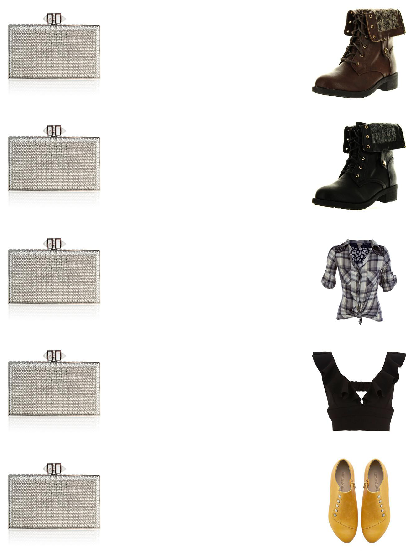

100%|██████████| 981/981 [06:56<00:00,  2.36it/s]


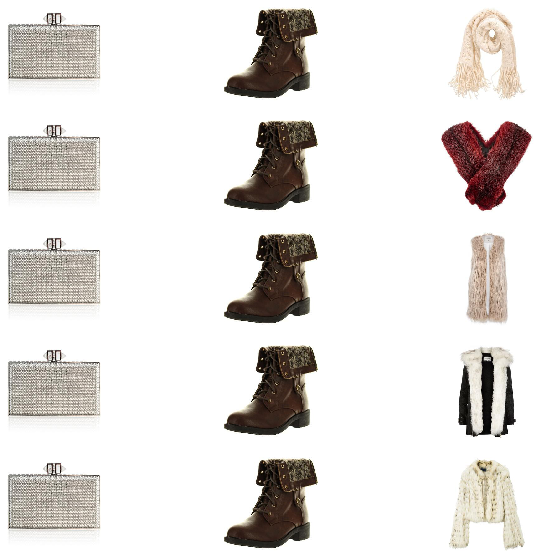

100%|██████████| 981/981 [06:55<00:00,  2.36it/s]


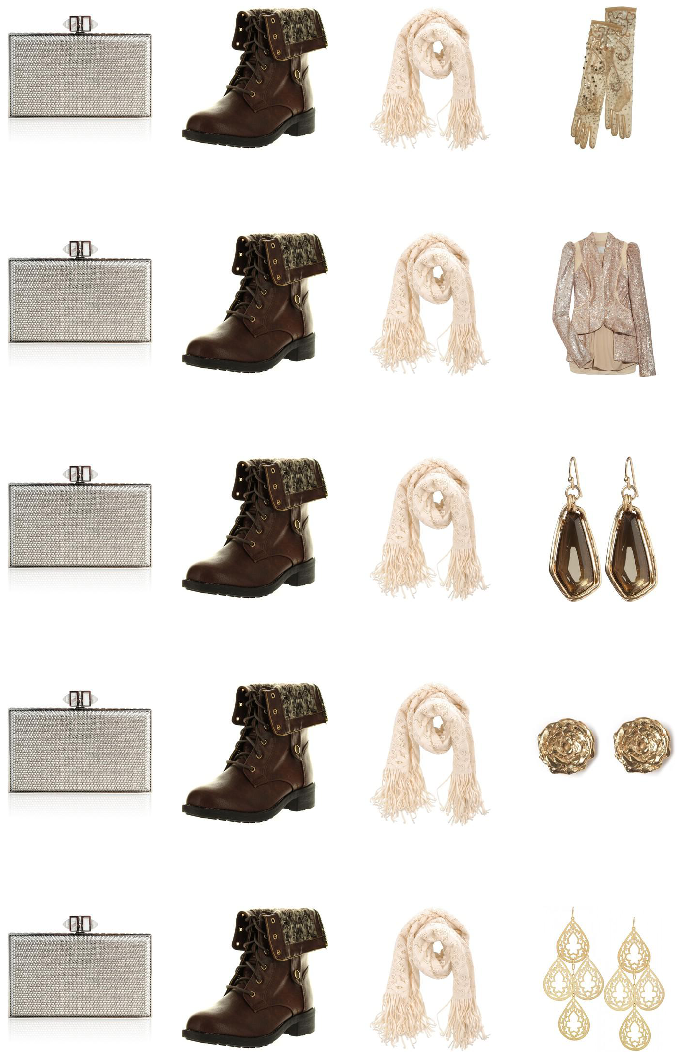

100%|██████████| 981/981 [06:57<00:00,  2.35it/s]


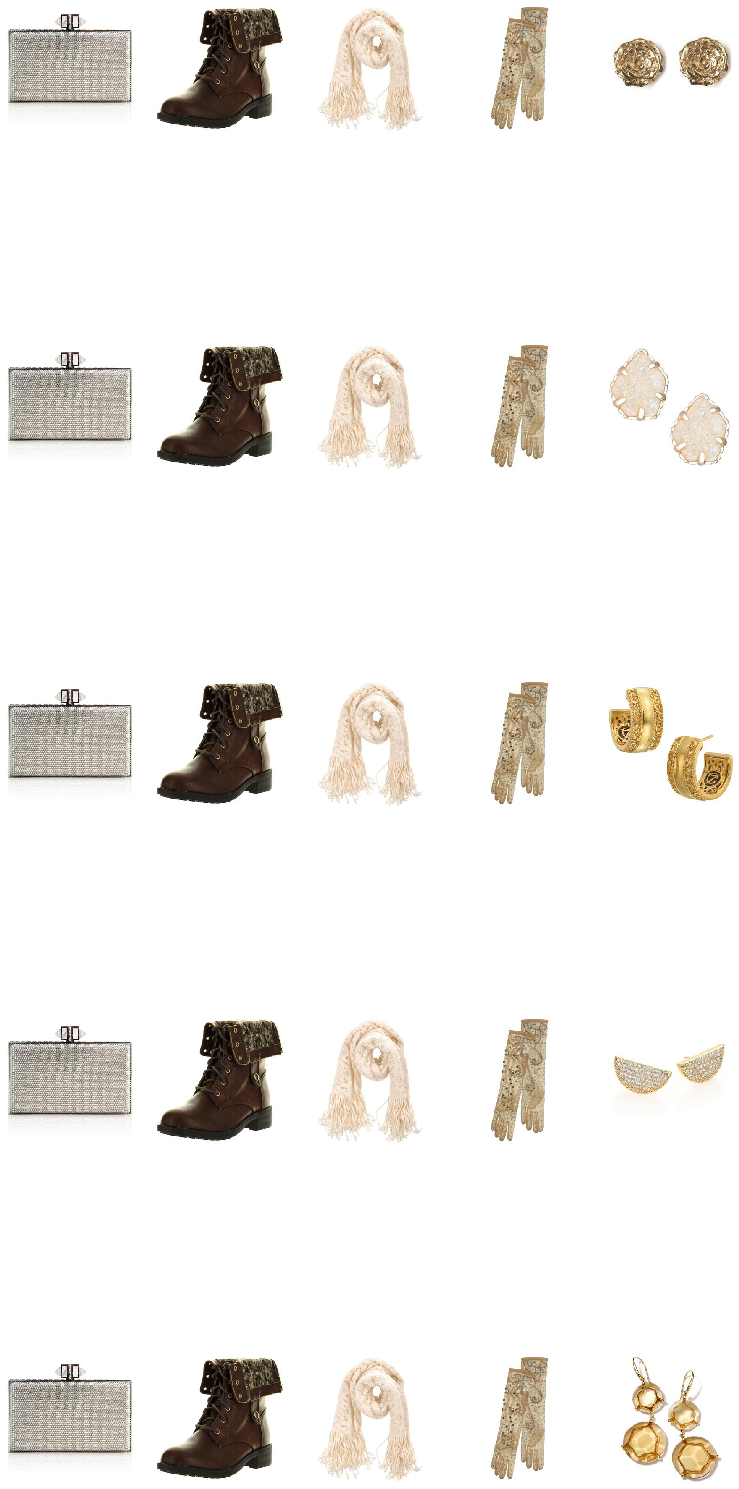

100%|██████████| 981/981 [06:52<00:00,  2.38it/s]


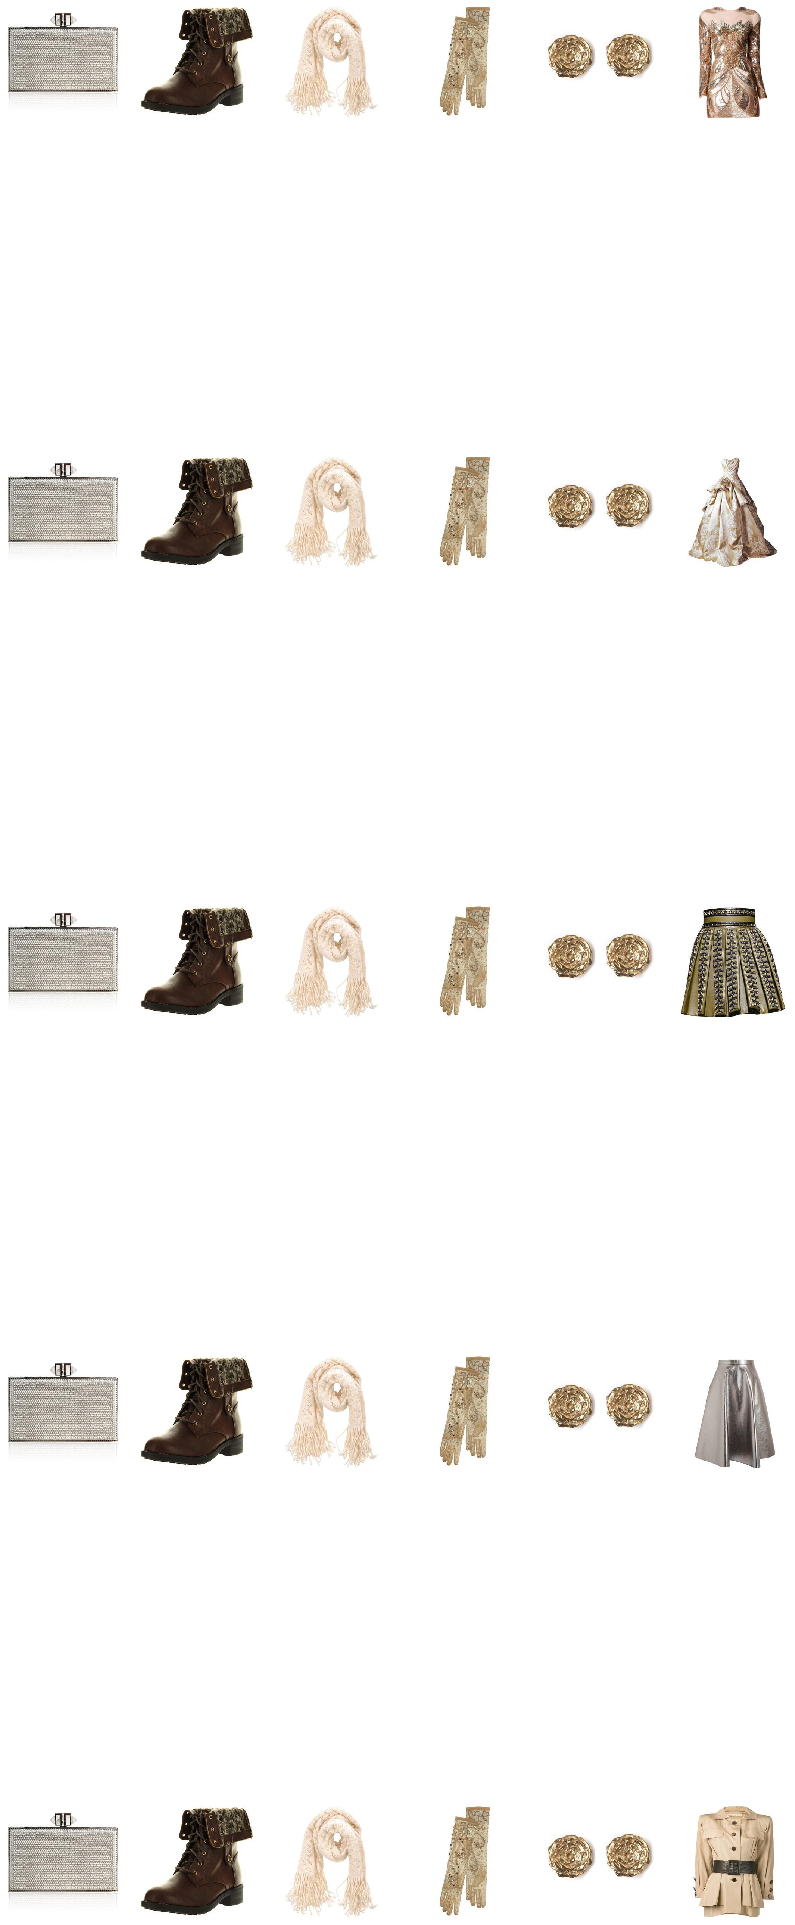

100%|██████████| 981/981 [06:47<00:00,  2.41it/s]


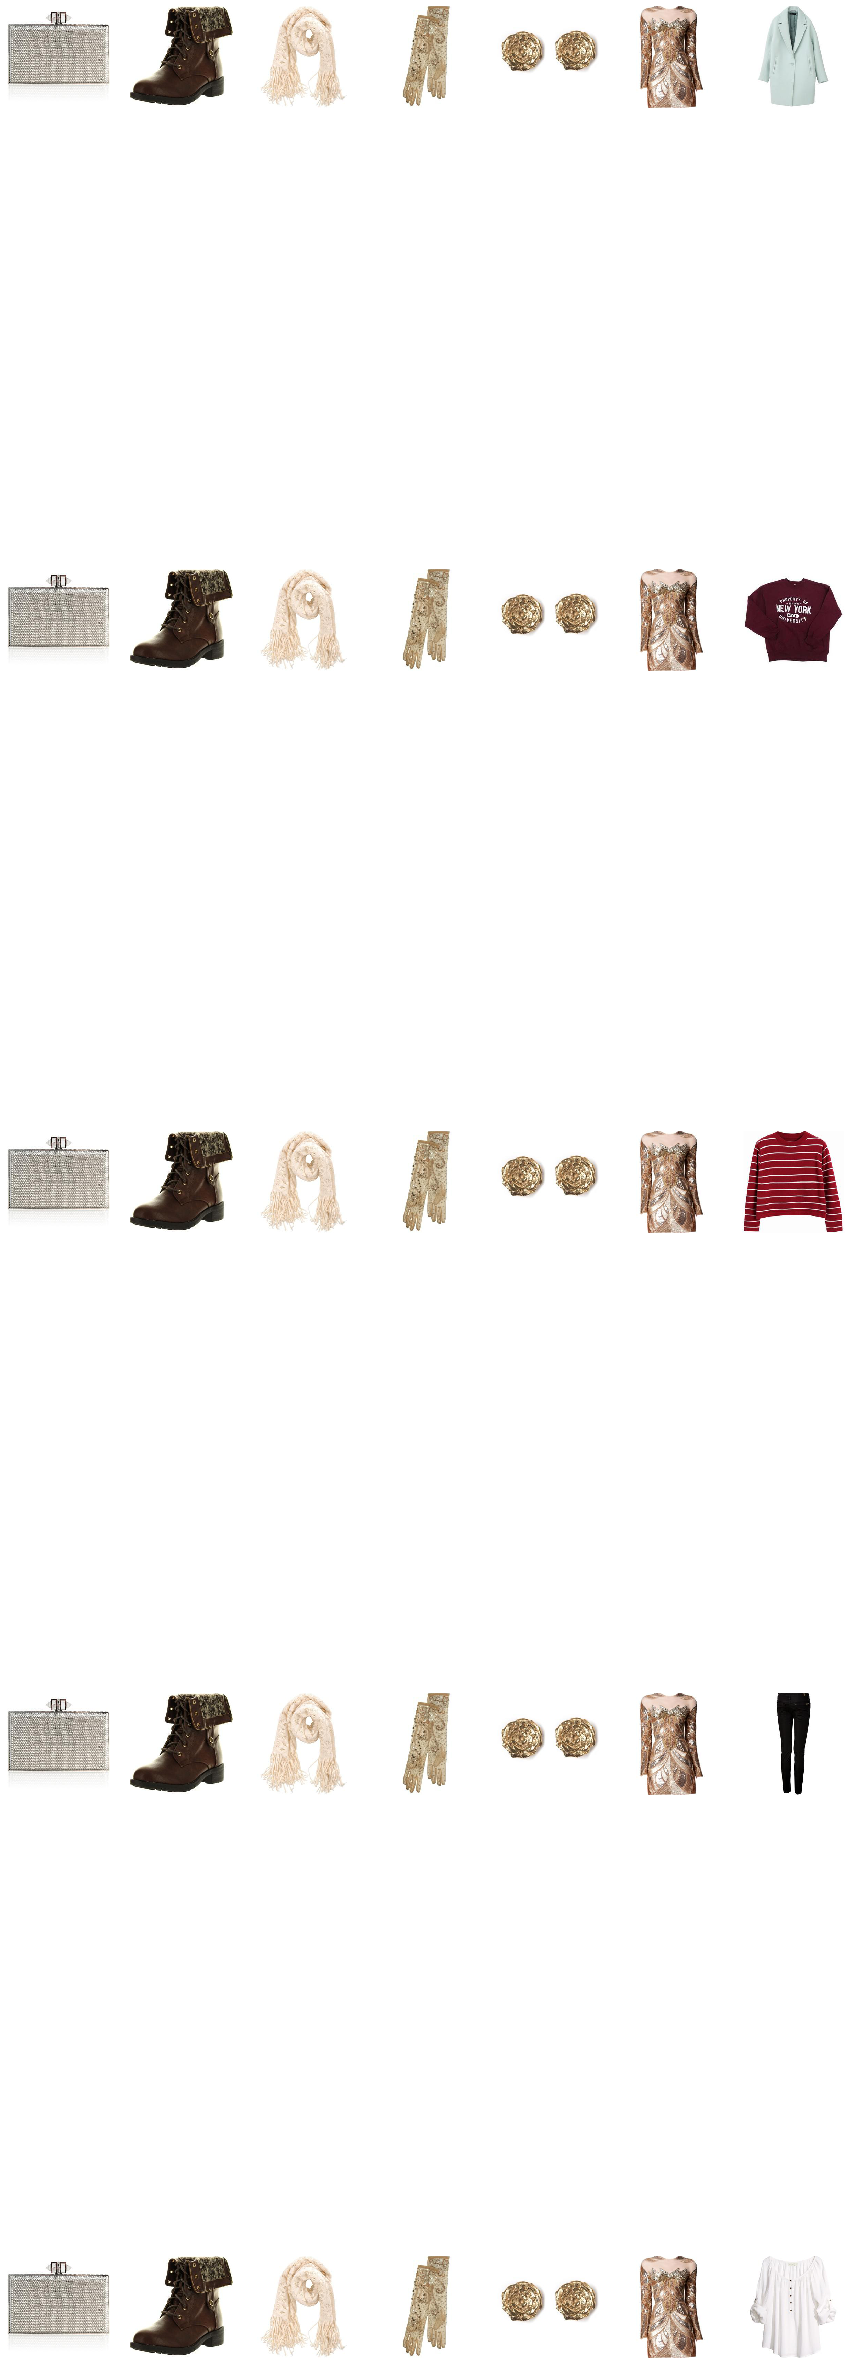

100%|██████████| 981/981 [05:47<00:00,  2.82it/s]


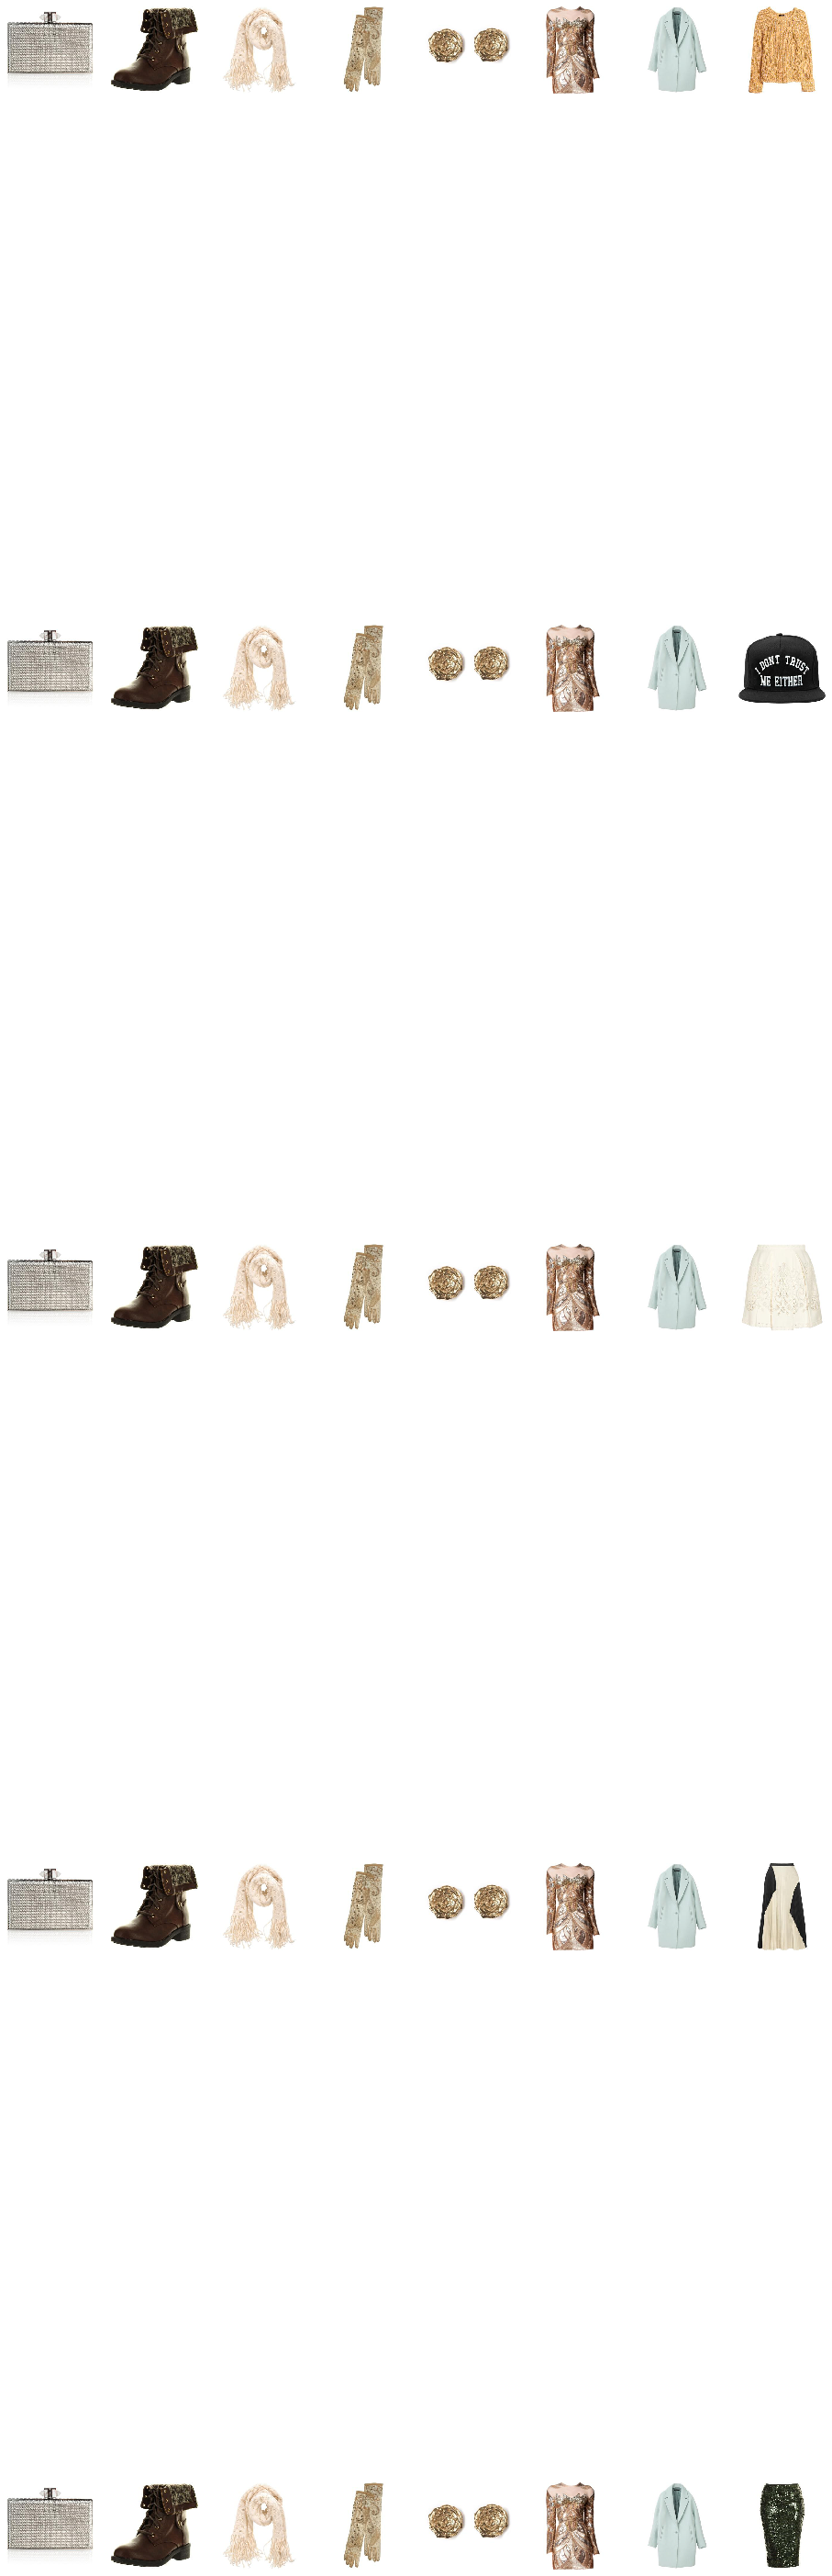

100%|██████████| 981/981 [06:25<00:00,  2.55it/s]


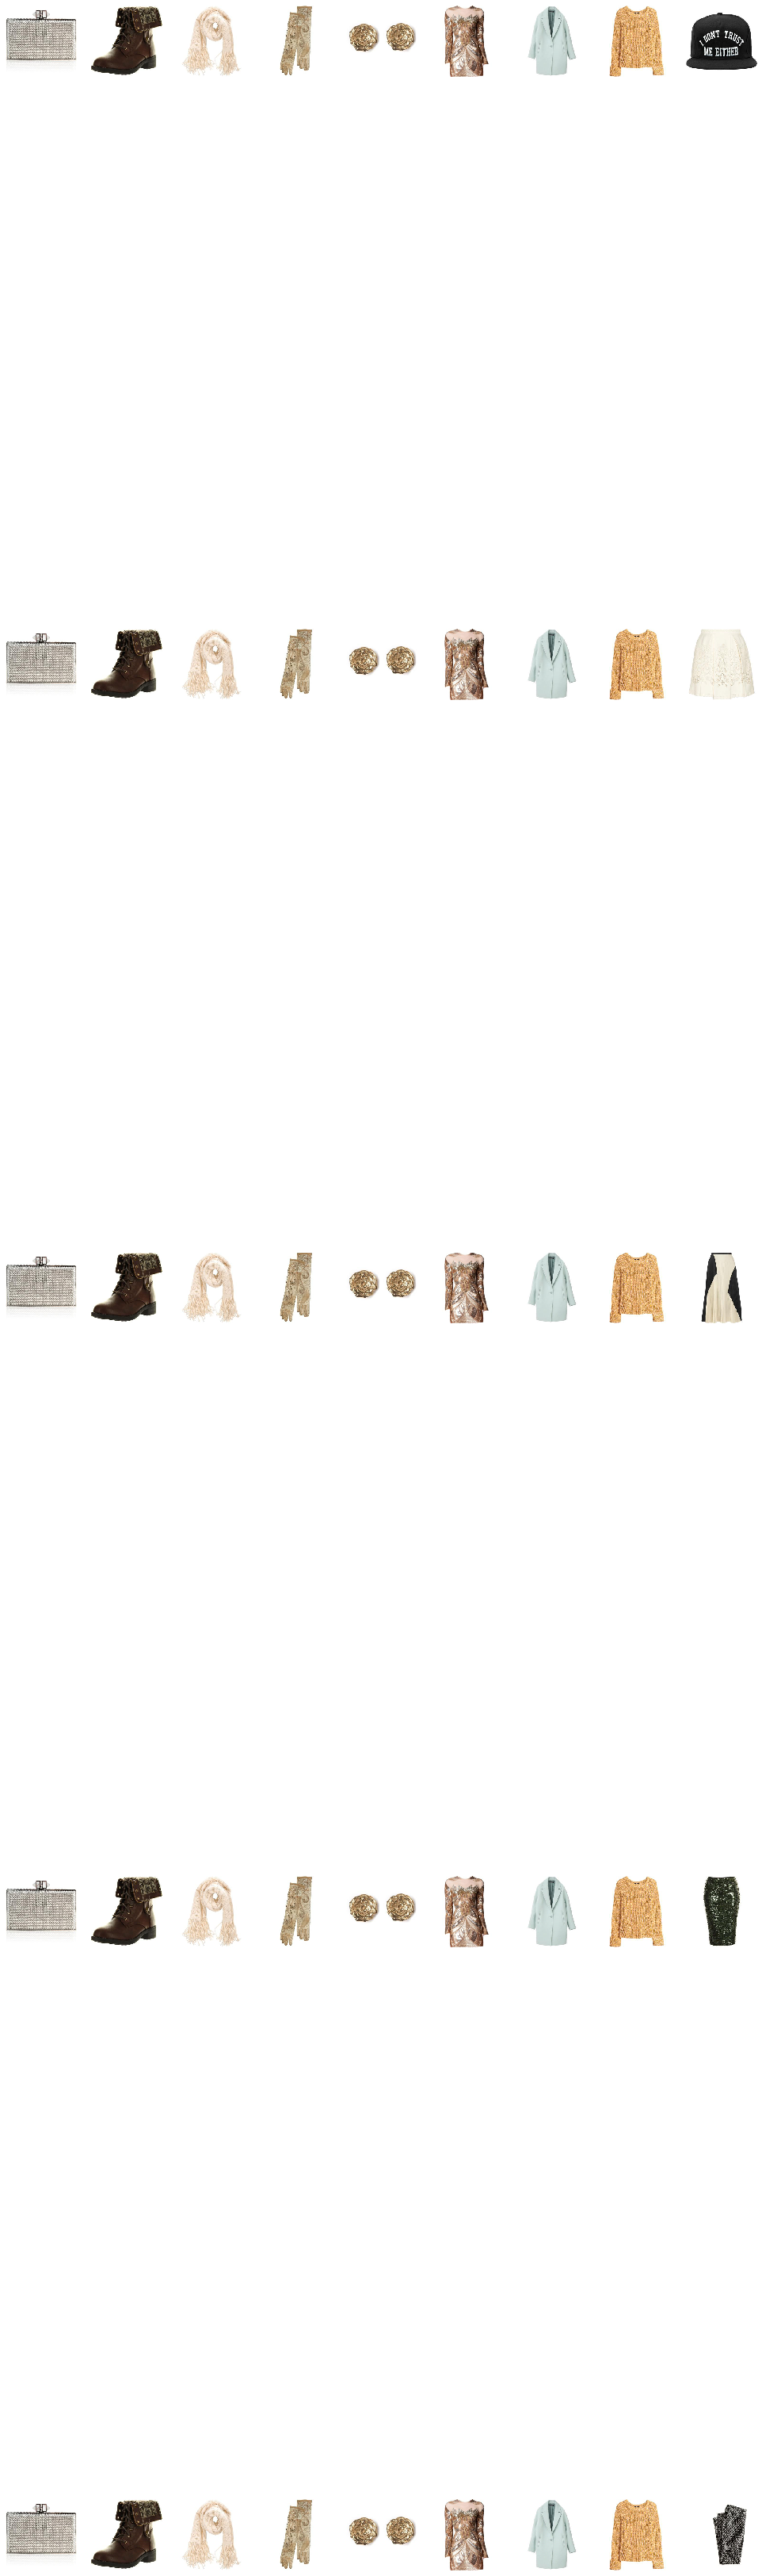

[['132621870',
  '162921642',
  '183420543',
  '5078143',
  '104135674',
  '102632919',
  '100018720',
  '100058394',
  '100076241'],
 ['132621870',
  '162921642',
  '183420543',
  '5078143',
  '104135674',
  '102632919',
  '100018720',
  '100058394',
  '100085586'],
 ['132621870',
  '162921642',
  '183420543',
  '5078143',
  '104135674',
  '102632919',
  '100018720',
  '100058394',
  '100087502'],
 ['132621870',
  '162921642',
  '183420543',
  '5078143',
  '104135674',
  '102632919',
  '100018720',
  '100058394',
  '100097445'],
 ['132621870',
  '162921642',
  '183420543',
  '5078143',
  '104135674',
  '102632919',
  '100018720',
  '100058394',
  '100097718']]

In [19]:
# '129978068'
create_outfit(query='132621870', model=model, max_item=8, beam_length=5)

100%|██████████| 981/981 [06:54<00:00,  2.37it/s]


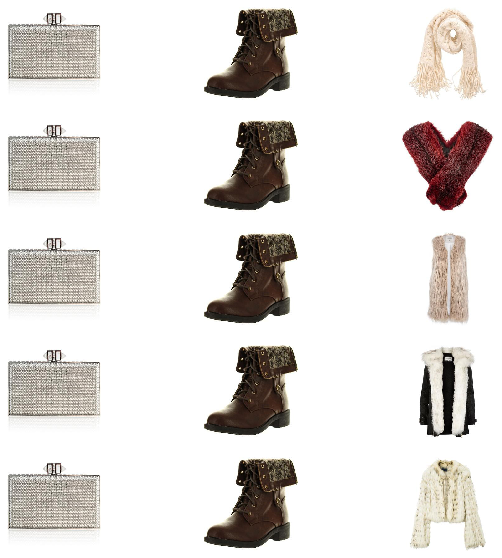

 49%|████▊     | 478/981 [03:22<03:32,  2.36it/s]


KeyboardInterrupt: 

In [48]:
create_outfit(query=['132621870', '162921642'], model=model, max_item=4, beam_length=5)

## Scratch

In [30]:
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")
with open(text_embedding_file, "rb") as fr:
    text_embedding_dict = pickle.load(fr)
print(f"Loaded {len(text_embedding_dict)} text embeddings")

Loaded 251008 text embeddings


In [17]:
query_item

'129978068'

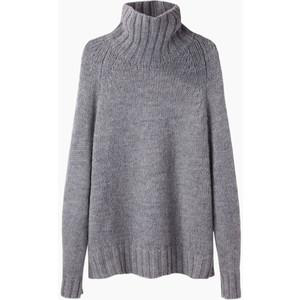

In [16]:
query = all_files[np.random.randint(len(all_files), size=1)[0]]
query = '/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits/images/129978068.jpg'
query_image = tf.keras.preprocessing.image.load_img(query)
query_item = query.split("/")[-1].split('.')[0]

query_image

In [17]:
test_gen = OutfitGen(embed_dir=embed_dir,
                     image_embed_file="effnet_tuned_polyvore.pkl",
                     text_embed_file="bert_polyvore.pkl",
                     batch_size=256,
                     max_len=8,
                     image_embedding_dim=1280,
                     query_item=query_item
                    )

In [9]:
for ii in range(5):
    inps, targs = test_gen[ii]
    print([x.shape for x in inps], targs.shape)

[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)


In [20]:
pbar = tqdm(range(len(test_gen)))
yhats, ys = [], []
score = []
for ii in pbar:
    x, items = test_gen[ii]  # batch size
    yhat = model(x)
    for cs, item in zip(yhat, items):
        heapq.heappush(score, (1-cs, str(item)))  # it's a min-heap

100%|██████████| 981/981 [07:41<00:00,  2.12it/s]


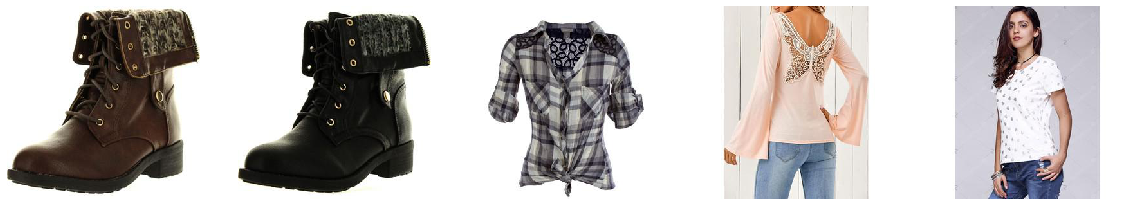

In [21]:
top_images = [heapq.heappop(score) for _ in range(5)]
plot_similar_images(top_images)

when the compatibility score is directly used in min-heap (basically returning the worst solutions)

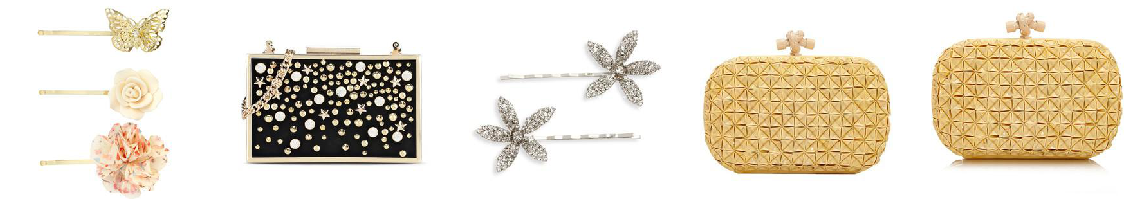

In [19]:
top_images = [heapq.heappop(score) for _ in range(5)]
plot_similar_images(top_images)

In [23]:
y

array([126851290, 109963356, 193976553, 141991205, 202171837, 185360913,
       173306482, 180805417, 156523809,  90590756, 142850345, 159566766,
       172414633, 204893970, 118901127, 190865514, 209155861,  73354973,
       187734223, 183503379, 198465664, 207796941, 173296250, 210497374,
       152342510, 209291202,  79137429, 118436830, 204322141, 211272710,
       210033239, 185818053])

In [ ]:
# Naive way - takes lot of time
qi_vec = image_embedding_dict[query.split("/")[-1].split('.')[0]].numpy()
qt_vec = text_embedding_dict[query.split("/")[-1].split('.')[0]]
for item, i_vec in tqdm(image_embedding_dict.items()):
    if item in text_embedding_dict:
        t_vec = text_embedding_dict[item]
        X1 = np.zeros((1, 8, 1280))
        X1[0, -1, :] = i_vec
        X1[0, -2, :] = qi_vec

        X2 = np.zeros((1, 8, 768))
        X2[0, -1, :] = t_vec
        X2[0, -2, :] = qt_vec

        i_score = model([X1, X2]).numpy()
        heapq.heappush(score, (i_score, item))


In [25]:
first_items = [c[1] for c in top_images]
first_items

['162921642', '162905789', '64033449', '194688455', '197471544']

In [6]:
from data_process import OutfitGen
query_item = '129978068'
test_gen2 = OutfitGen(embed_dir=embed_dir,
                      image_embed_file="effnet_tuned_polyvore.pkl",
                      text_embed_file="bert_polyvore.pkl",
                      batch_size=256,
                      max_len=8,
                      image_embedding_dim=1280,
                      query_item=[query_item, '162921642'],
                      )

In [7]:
pbar = tqdm(range(len(test_gen2)))
score_2 = []
for ii in pbar:
    x, items = test_gen2[ii]  # batch size
    yhat = model(x)
    for cs, item in zip(yhat, items):
        heapq.heappush(score_2, (1-cs, str(item)))  # it's a min-heap

100%|██████████| 981/981 [07:20<00:00,  2.22it/s]


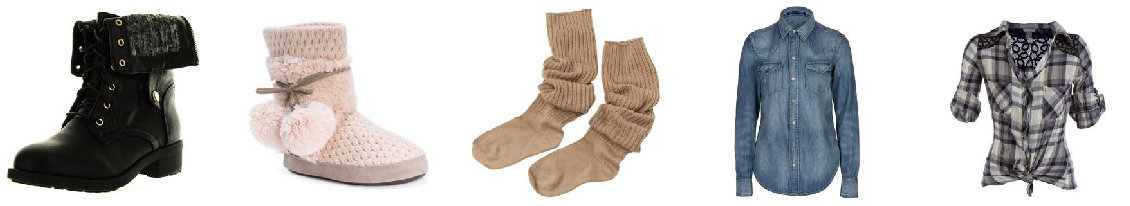

In [8]:
top_images = [heapq.heappop(score_2) for _ in range(5)]
plot_similar_images(top_images)

In [28]:
for ii in range(5):
    inps, targs = test_gen2[ii]
    print([x.shape for x in inps], targs.shape)

[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)
[(256, 8, 1280), (256, 8, 768)] (256,)


In [13]:
pv_items[query_item]

{'url_name': 'moderne didion chunky turtleneck',
 'description': 'From Moderne, a soft wool oversized sweater with a relaxed chunky ribbed turtleneck.  Slightly elongated sleeves feature slit detail at wrists & hem  Dropped armholes & exaggerated body for an oversized fit  Neck can be worn up or folded down  Soft, slightly nubby plain knit with rib finishing',
 'catgeories': ["Women's Fashion",
  'Tops',
  'Sweaters',
  'La Garçonne Moderne sweaters'],
 'title': 'Moderne Didion Chunky Turtleneck',
 'related': ['Woolen sweater',
  'Long sleeve tops',
  'Turtle neck sweater',
  'Oversized sweaters',
  'Chunky sweater',
  'Short-sleeve turtleneck sweaters'],
 'category_id': '19',
 'semantic_category': 'tops'}

In [17]:
with open(os.path.join(train_dir, "train.json"), 'r') as fr:
    pv_train_pos = json.load(fr)


In [27]:
def plot_pv_outfit(outfit):
    items = outfit['items']
#     cats = outfit['low_level_cats']
    print(f"Total {len(items)} items in the outfit ({pv_outfits[outfit['set_id']]['title']})")
    if len(items) <= 8:
        nrows, ncols = 1, len(items)
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,5))
        for ii in range(ncols):
            item = items[ii]['item_id']
            img = plt.imread(os.path.join(image_dir, item + ".jpg"))
            imgplot = axis[ii].imshow(img)
#             img = Image.open(os.path.join(image_dir, item + ".jpg"))
#             print(img.width, img.height)
#             axis[ii].title.set_text(pv_items[item])
            axis[ii].axis('off')
        plt.show()
    else:
        nrows, ncols = len(items) % 5 + 1, 5
        figure, axis = plt.subplots(nrows, ncols, figsize=(20,10))
        count = 0
        for ii in range(nrows):
            for jj in range(ncols):
                item = items[count]['item_id']
                img = plt.imread(os.path.join(image_dir, item + ".jpg"))
#                 print(img.width, img.height)
                imgplot = axis[ii][jj].imshow(img)
#                 axis[ii][jj].title.set_text(cats[count])
                axis[ii][jj].axis('off')
                count += 1
                if count >= len(items):
                    break
        plt.show()


In [23]:
pv_train_pos[0]

{'items': [{'item_id': '132621870', 'index': 1},
  {'item_id': '153967122', 'index': 2},
  {'item_id': '171169800', 'index': 3},
  {'item_id': '162799044', 'index': 4},
  {'item_id': '172538912', 'index': 5},
  {'item_id': '172312529', 'index': 6}],
 'set_id': '199244701'}

Total 6 items in the outfit (Drop Earrings)


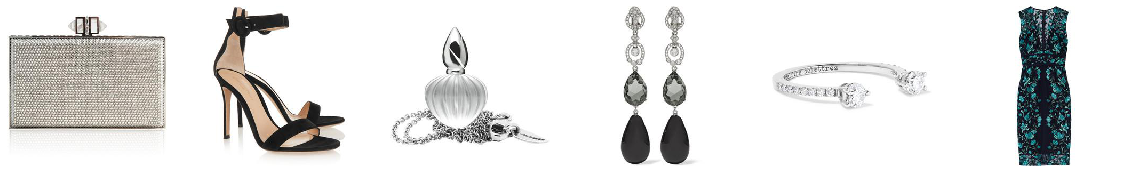

In [28]:
plot_pv_outfit(pv_train_pos[0])

In [33]:
def evaluate_outfit(items, image_dict, text_dict, model):
    X1 = np.zeros((1, 8, 1280))
    X2 = np.zeros((1, 8, 768))
    for ii, item in enumerate(items):
        img_vec = image_dict[item].numpy()
        txt_vec = text_dict[item]
        X1[0, 7-ii, :] = img_vec
        X2[0, 7-ii, :] = txt_vec
    score = model([X1, X2]).numpy()
    return score

In [34]:
evaluate_outfit([it['item_id'] for it in pv_train_pos[0]['items']], image_embedding_dict, text_embedding_dict, model)

array([[0.7129911]], dtype=float32)

In [45]:
evaluate_outfit(['132621870',
  '162921642',
  '183420543',
  '5078143',
  '104135674',
  '102632919',
#   '100018720',
#   '100058394',
], image_embedding_dict, text_embedding_dict, model)

array([[1.]], dtype=float32)

In [44]:
evaluate_outfit(['132621870',
  '162921642',
  '183420543',
  '5078143',
], image_embedding_dict, text_embedding_dict, model)

array([[0.99999857]], dtype=float32)

## Evaluate a model on Test Data

In [9]:
import tensorflow as tf
import json
import os

In [2]:
data_type = "nondisjoint"
model_type = "rnn"
max_seq_len = 8
model = tf.keras.models.load_model(f"compatibility_{data_type}_{model_type}_model_{max_seq_len}")
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8, 1280)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 8, 768)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_Sum (TensorFlowOpLa (None, 8)            0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sum_1 (TensorFlowOp (None, 8)            0           input_5[0][0]                    
________________________________________________________________________________________________

In [5]:
data_dir = "/recsys_data/RecSys/fashion/polyvore-dataset"
data_file = "fashion_compatibility_prediction.txt"
with open(os.path.join(data_dir, data_file), 'r') as fr:
    data_X, data_y = [], []
    for line in fr:
        elems = line.strip().split()
        data_y.append(elems[0])
        data_X.append(elems[1:])
print(f"Read {len(data_X)} examples")

Read 7076 examples


In [30]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "disjoint" # "nondisjoint", "disjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"

train_json = "train_no_dup.json"
valid_json = "valid_no_dup.json"
test_json = "test_no_dup.json"

train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"

with open(os.path.join(data_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(data_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(data_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)

with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_X, train_y = [], []
    for line in fr:
        elems = line.strip().split()
        train_y.append(elems[0])
        train_X.append(elems[1:])

with open(os.path.join(train_dir, valid_file), 'r') as fr:
    valid_X, valid_y = [], []
    for line in fr:
        elems = line.strip().split()
        valid_y.append(elems[0])
        valid_X.append(elems[1:])

with open(os.path.join(train_dir, test_file), 'r') as fr:
    test_X, test_y = [], []
    for line in fr:
        elems = line.strip().split()
        test_y.append(elems[0])
        test_X.append(elems[1:])

print(f"Total {len(train_X)}, {len(valid_X)}, {len(test_X)} examples in train, validation and test split, respectively")

# item_dict = {}
# for ii, outfit in enumerate(train_pos):
#     items = outfit['items']
#     mapped = train_X[ii]
#     item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
# print(len(item_dict))

# for ii, outfit in enumerate(valid_pos):
#     items = outfit['items']
#     mapped = valid_X[ii]
#     item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
# print(len(item_dict))

# for ii, outfit in enumerate(test_pos):
#     items = outfit['items']
#     mapped = test_X[ii]
#     item_dict.update({jj:kk['item_id'] for jj, kk in zip(mapped, items)})
# print(len(item_dict))

Total 33990, 6000, 30290 examples in train, validation and test split, respectively


In [50]:
item_dict = {}
for ii, outfit in enumerate(train_pos):
    oid = outfit['set_id']
    items = [x['image'].split('id=')[1] for x in outfit['items']]
    indices = [x['index'] for x in outfit['items']]
    item_dict.update({f"{oid}_{jj}":item for jj, item in zip(indices, items)})
print(len(item_dict))

for ii, outfit in enumerate(valid_pos):
    oid = outfit['set_id']
    items = [x['image'].split('id=')[1] for x in outfit['items']]
    indices = [x['index'] for x in outfit['items']]
    item_dict.update({f"{oid}_{jj}":item for jj, item in zip(indices, items)})
print(len(item_dict))

for ii, outfit in enumerate(test_pos):
    oid = outfit['set_id']
    items = [x['image'].split('id=')[1] for x in outfit['items']]
    indices = [x['index'] for x in outfit['items']]
    item_dict.update({f"{oid}_{jj}":item for jj, item in zip(indices, items)})
print(len(item_dict))

114806
123876
142480


In [14]:
include_text = True
use_image_embedding = True # False # True
use_graphsage = False
batch_size = 32
max_seq_len = 8
image_embedding_dim = 1280
image_embedding_file = os.path.join(embed_dir, "effnet_tuned_polyvore.pkl")
text_embedding_file = os.path.join(embed_dir, "bert_polyvore.pkl")

In [51]:
from data_process import CustomDataGen
data_gen = CustomDataGen(data_X, data_y, 
                          item_dict, 
                          pv_items, 
                          image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding=use_image_embedding,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          number_items_in_batch=150,
                          variable_length_input=True,
                         )


In [18]:
from tqdm import tqdm
def get_accuracy_auc(data_gen):
    m = tf.keras.metrics.BinaryAccuracy()
    m2 = tf.keras.metrics.AUC()
    acc_list = []
    pbar = tqdm(range(len(data_gen)))
    ys, yhats = [], []
    for ii in pbar:
        x, y = data_gen[ii]  # batch size
        yhat = model(x)
        m.update_state(y, yhat)
        batch_acc = m.result().numpy()
        acc_list.append(batch_acc)
        pbar.set_description("Batch accuracy %g" % batch_acc)
        ys.append(y)
        yhats.append(yhat)
    print(f"Average Accuracy: {np.mean(acc_list)}")
    big_y = np.concatenate(ys, axis=0)
    big_yh = np.concatenate(yhats, axis=0)
    m2.update_state(big_y, big_yh)
    auc = m2.result().numpy()
    print(f"AUC: {auc}")


In [52]:
get_accuracy_auc(data_gen)

  0%|          | 0/222 [00:00<?, ?it/s]


KeyError: '49340822'